# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


В нашем распоряжении файл, состоящий из 2 столбцов (название файла и возраст) и 7591 строк (изображений).

Построим график распределения возраста в выборке:

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

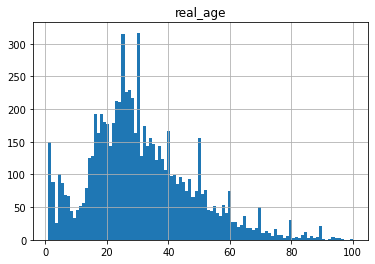

In [4]:
labels.hist(bins=100)

Большинство людей в выборке находятся в возрасте от 18 до 30 лет. Видим провал в диапазоне 8-10 лет.

In [5]:
features, target = next(train_gen_flow)

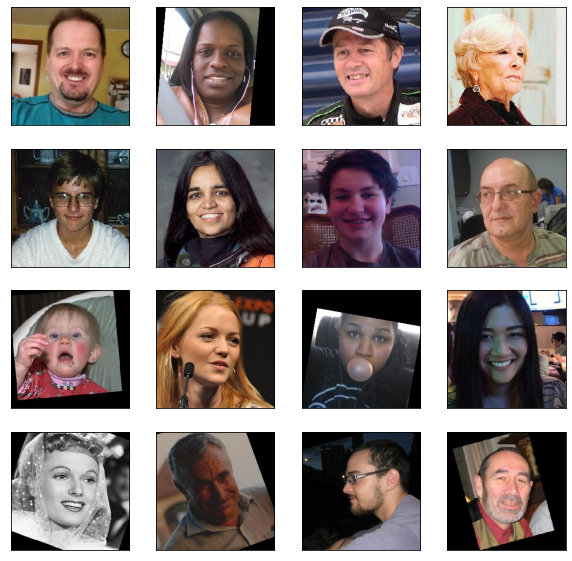

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

Вывод:

В датасете находятся фотографии людей разного возраста, пола, расы. Также можно заметить, что присутсвуют объекты, которые закрывают лицо (жвачка, микрофон, головной убор). Фотографии сделаны под разными углами, в фас и профиль, есть скрины распечатанных фотоизображений. Перечисленные выше детали могут повлиять на обучение модели.

Все фотографии ориентированы верно, перевернутые снимки не наблюдаются, поэтому в повороте не нуждаются. В выборке есть как цветные изборажения, так и черно-белые. Изображения отличаются по размеру. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset = 'validation',
        seed=12345)
    
    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-08-10 19:11:46.339838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-10 19:11:48.456648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 227.6586 - mae: 10.9069 - val_loss: 429.9777 - val_mae: 15.6904
Epoch 2/5
356/356 - 38s - loss: 86.8042 - mae: 7.1315 - val_loss: 196.4715 - val_mae: 10.9086
Epoch 3/5
356/356 - 38s - loss: 59.7417 - mae: 5.8837 - val_loss: 82.1521 - val_mae: 6.7671
Epoch 4/5
356/356 - 38s - loss: 41.5020 - mae: 4.9104 - val_loss: 121.1918 - val_mae: 8.6745
Epoch 5/5
356/356 - 38s - loss: 33.3012 - mae: 4.4130 - val_loss: 80.2212 - val_mae: 6.8718
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 80.2212 - mae: 6.8718
Test MAE: 6.8718

```

## Анализ обученной модели

Для обучения модели была применена нейронная сеть с архитектурой ResNet с применением сверточных сетей, предварительно обученнных на ImageNet. Обучение было произведено на 5 эпохах.

Удалось добиться следующих результатов:

* MAE на обучающей выборке: 4.4130
* MAE на тестовой выборке: 6.8718

Данные показатели говорят о том, что полученнная модель позволяет с высокой точностью предсказывать возраст покупателей. 

Параметры модели:

Sequential (последовательная модель), к которой добален backbone (слой ResNet50), затем GlobalAveragePooling2D (пулинг с окном во весь тензор), затем Dense (полносвязный слой с активацией нейронов ReLU). 

Параметры оптимизированы с помощью алгоритма Adam (learning rate = 0.0001).




Применение компьютерного зрения в прикассовой зоне супермаркета может быть эффективным инструментом сегментирования аудитории покупателей и совершенствования таргетинга маркетинговых предложений. Так, например, анализ возраста покупателей может помочь в подборе купонов на следующие покупки. Определение возраста покупателей так же может помочь понять суточный ритм супермаркета: когда покупки совершаются пенсионерами, а когда экономически активным населением, что также поможет оптимизировать промо-акции. В то же время, компьютерное зрение представляется не лучшим способом контроля продажи алкоголя несовершеннолетним, так как максимальная ошибка в определении возраста покупателя составляет 7 лет, что является слишком значительным отклонением для успешного применения на практике.